In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import defaultdict
from tqdm import tqdm
from scipy.linalg import inv

PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [3]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='full_window', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
                    #   mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')

da.load_results_da()
center_idx_ctxt = da.queries[-1].get_center_idx()
winsize_ctxt = da.queries[-1].winsize
if center_idx_ctxt < 0:
    center_idx_ctxt = winsize_ctxt + center_idx_ctxt
da.seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


In [4]:
def diff(x1, x2):
    d = np.abs(x1 - x2)
    return np.minimum(d, 360-d)

def get_phi_psi_dist(q, seq_ctxt):
    seq = q.get_subseq(seq_ctxt)
    phi_psi_dist = q.results_window[q.results_window.seq == seq]
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]
    phi_psi_dist = phi_psi_dist.dropna(axis=0)
    return phi_psi_dist

def get_xrays(ins, q, seq_ctxt, return_df=False):
    center_idx = q.get_center_idx_pos()
    xray_pos = ins.xray_phi_psi[ins.xray_phi_psi.seq_ctxt == seq_ctxt].pos.iloc[0]
    xrays = ins.xray_phi_psi[(ins.xray_phi_psi.pos >= xray_pos-center_idx) & (ins.xray_phi_psi.pos < xray_pos-center_idx+q.winsize)].copy()
    xray_point = np.concatenate([xrays['phi'].values, xrays['psi'].values])
    if return_df:
        return xray_point, xrays
    return xray_point

def get_preds(ins, q, seq_ctxt):
    center_idx = q.get_center_idx_pos()
    pred_pos = ins.phi_psi_predictions[ins.phi_psi_predictions.seq_ctxt == seq_ctxt].pos.unique()
    if len(pred_pos) == 0:
        print(f"No predictions for {seq_ctxt}")
    if len(pred_pos) > 1:
        print(f"Multiple predictions for {seq_ctxt}")
        raise ValueError
    pred_pos = pred_pos[0]
    preds = ins.phi_psi_predictions[(ins.phi_psi_predictions.pos >= pred_pos-center_idx) & (ins.phi_psi_predictions.pos < pred_pos-center_idx+q.winsize)].copy()
    preds = preds[['protein_id', 'pos', 'phi', 'psi']].pivot(index='protein_id', columns='pos', values=['phi', 'psi'])
    preds.columns = [f'{c[0]}_{c[1]-pred_pos+center_idx}' for c in preds.columns.to_flat_index()]
    preds = preds.dropna(axis=0)
    return preds

def calc_xray_score(phi_psi_dist, xrays, q, intracluster_dists):
    # cluster_daves = phi_psi_dist.groupby('cluster').mean()
    # nearest_cluster_idx = np.linalg.norm(diff(cluster_aves.values, xrays), axis=1).argmin()
    # nearest_cluster = cluster_aves.iloc[nearest_cluster_idx].name

    # values = np.vstack([phi_psi_dist.iloc[:,:q.winsize*2], xrays[np.newaxis,:]])
    # precomputed_dists = np.linalg.norm(diff(values[:,np.newaxis], values), axis=2)
    # xray_sil = silhouette_samples(
    #     precomputed_dists, 
    #     np.append(phi_psi_dist.cluster.values, nearest_cluster),
    #     metric='precomputed'
    # )[-1]

    # return xray_sil, nearest_cluster

    d = np.linalg.norm(diff(xrays[np.newaxis,:], phi_psi_dist.iloc[:,:q.winsize*2].values), axis=1)
    d = pd.DataFrame({'d': d, 'c': phi_psi_dist.cluster})
    nearest_cluster = d.groupby('c').d.mean().idxmin()

    # xray_dist = d.groupby('c').d.mean().min()
    # xray_dist = xray_dist / intracluster_dists[nearest_cluster]

    # mahalanobis distance

    return xray_dist, nearest_cluster

# def calc_and_assign_sil_score(q, preds, phi_psi_dist):
#     cluster_aves = phi_psi_dist.groupby('cluster').mean().iloc[:,:q.winsize*2]
#     nearest_cluster_idxs = np.linalg.norm(diff(preds.iloc[:,:q.winsize*2].values[:,np.newaxis], cluster_aves.values), axis=2).argmin(axis=1)
#     preds['cluster'] = cluster_aves.iloc[nearest_cluster_idxs].index.values

#     preds['sil'] = np.nan
#     distances = np.linalg.norm(diff(preds.iloc[:,:q.winsize*2].values[:, np.newaxis], phi_psi_dist.iloc[:,:q.winsize*2].values), axis=2)
#     for ci in phi_psi_dist.cluster.unique():
#         dists_ci = distances[preds.cluster.values == ci]
#         a = dists_ci[:, phi_psi_dist.cluster == ci].mean(axis=1)

#         bs = []
#         for cj in phi_psi_dist[phi_psi_dist.cluster != ci].cluster.unique():
#             # bs.append(dists_ci[:, phi_psi_dist.cluster == cj].mean(axis=1))
#             bs.append(dists_ci[:, phi_psi_dist.cluster == cj].sum(axis=1) / sum(phi_psi_dist.cluster == cj))
#         bs = np.vstack(bs)
#         b = np.min(bs, axis=0)

#         sils = (b - a) / np.maximum(a, b)
#         preds.loc[preds.cluster == ci, 'sil'] = sils

def calc_score(q, preds, phi_psi_dist, intracluster_dists):
    # normalize by intracluster distnace of nearest cluster
    d = np.linalg.norm(diff(preds.iloc[:,:q.winsize*2].values[:,np.newaxis], phi_psi_dist.iloc[:,:q.winsize*2].values), axis=2)
    average_dists = []
    clusters = phi_psi_dist.cluster.unique()
    for c in clusters:
        average_dists.append(d[:,phi_psi_dist.cluster == c].mean(axis=1))
    average_dists = np.array(average_dists).T
    min_dists = average_dists.min(axis=1)
    nearest_clusters = average_dists.argmin(axis=1)
    nearest_cluster_intradists = np.array([intracluster_dists[c] for c in clusters[nearest_clusters]])

    return min_dists / nearest_cluster_intradists

def calc_intra_cluster(phi_psi_dist, precomputed_dists):
    ds = {}
    for c in phi_psi_dist.cluster.unique():
        d = precomputed_dists[phi_psi_dist.cluster == c][:,phi_psi_dist.cluster == c]
        ds[c] = d.sum() / (d.shape[0] * (d.shape[0]-1))
    return ds

def precompute_dists(phi_psi_dist):
    def diff(x1, x2):
            d = np.abs(x1 - x2)
            return np.minimum(d, 360-d)
    precomputed_dists = np.linalg.norm(diff(phi_psi_dist.values[:,np.newaxis], phi_psi_dist.values), axis=2)
    return precomputed_dists
    
def assign_clusters(phi_psi_dist, precomputed_dists, eps=75):
    phi_psi_dist['cluster'] = DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(precomputed_dists).labels_
    n_clusters = len(phi_psi_dist.cluster.unique())
    return n_clusters

In [41]:
ins = da
q = ins.queries[0]
seq_ctxt = 'RLGIVFL'
phi_psi_dist = get_phi_psi_dist(q, seq_ctxt)
xrays = get_xrays(ins, q, seq_ctxt)
preds = get_preds(ins, q, seq_ctxt)
precomputed_dists = precompute_dists(phi_psi_dist.iloc[:,:q.winsize*2])
n_clusters = assign_clusters(phi_psi_dist, precomputed_dists)
intracluster_dists = calc_intra_cluster(phi_psi_dist, precomputed_dists)

d = np.linalg.norm(diff(xrays[np.newaxis,:], phi_psi_dist.iloc[:,:q.winsize*2].values), axis=1)
d = pd.DataFrame({'d': d, 'c': phi_psi_dist.cluster})
nearest_cluster = d.groupby('c').d.mean().idxmin()

# estimate covariance matrix
cluster_points = phi_psi_dist[phi_psi_dist.cluster == nearest_cluster].iloc[:,:q.winsize*2].values
cluster_avg = cluster_points.mean(axis=0)

diffs = diff(cluster_points, cluster_avg)


# cov = []
# for diffi in diffs:
#     diffi = diffi.reshape(-1, 1)
#     cov.append(diffi @ diffi.T)
# cov = np.array(cov).sum(axis=0) / (diffs.shape[0] - 1)
cov = (diffs[...,np.newaxis] @ diffs[:,np.newaxis]).sum(axis=0) / (diffs.shape[0] - 1)
icov = inv(cov)

# xray_score, nearest_cluster = calc_xray_score(phi_psi_dist, xrays, q, intracluster_dists)    
# sorted_idx = phi_psi_dist.reset_index().sort_values('cluster').index.values
# sns.heatmap(precomputed_dists[sorted_idx][:,sorted_idx])
# cluster_idx = phi_psi_dist.reset_index()[phi_psi_dist.reset_index().cluster == nearest_cluster].index.values
# sns.heatmap(precomputed_dists[cluster_idx][:,cluster_idx])

In [42]:
icov

array([[ 0.01961378,  0.00318988, -0.00242499,  0.00303022, -0.00896129,
        -0.00413245, -0.00057977, -0.00354487],
       [ 0.00318988,  0.03529716, -0.01277713,  0.00687366, -0.02176937,
         0.00041113, -0.00163636, -0.00558512],
       [-0.00242499, -0.01277713,  0.05396442, -0.00093788,  0.00628715,
        -0.01449051, -0.01918304, -0.00133772],
       [ 0.00303022,  0.00687366, -0.00093788,  0.02439221, -0.00663812,
        -0.01018126, -0.00692333, -0.00841327],
       [-0.00896129, -0.02176937,  0.00628715, -0.00663812,  0.02639429,
        -0.0039551 , -0.00209742,  0.00471074],
       [-0.00413245,  0.00041113, -0.01449051, -0.01018126, -0.0039551 ,
         0.03754101,  0.00659181, -0.00185135],
       [-0.00057977, -0.00163636, -0.01918304, -0.00692333, -0.00209742,
         0.00659181,  0.0307334 , -0.00244919],
       [-0.00354487, -0.00558512, -0.00133772, -0.00841327,  0.00471074,
        -0.00185135, -0.00244919,  0.01243795]])

<Axes: >

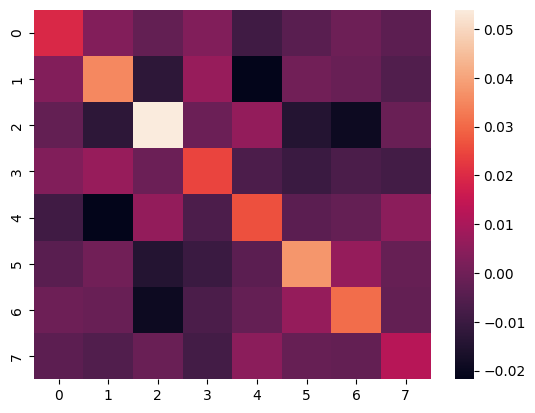

In [43]:
sns.heatmap(icov)

In [19]:
ins = da
q = ins.queries[0]
ins.phi_psi_predictions['new_score'] = np.nan
ins.xray_phi_psi['new_score'] = np.nan
ins.xray_phi_psi['cluster_sil_score'] = np.nan

for seq_ctxt in tqdm(ins.seqs_for_window[1:]):
    phi_psi_dist = get_phi_psi_dist(q, seq_ctxt)
    xrays = get_xrays(ins, q, seq_ctxt)
    preds = get_preds(ins, q, seq_ctxt)

    if xrays.shape[0] != q.winsize*2:
        print(f"Xray data for {seq_ctxt} is incomplete")
        continue
    if preds.shape[0] == 0:
        print(f"No predictions for {seq_ctxt}")
        continue
    if phi_psi_dist.shape[0] == 0:
        print(f"No pdbmine data for {seq_ctxt}")
        continue

    precomputed_dists = precompute_dists(phi_psi_dist.iloc[:,:q.winsize*2])
    n_clusters = assign_clusters(phi_psi_dist, precomputed_dists)
    precomputed_dists = precomputed_dists[phi_psi_dist.cluster != -1][:,phi_psi_dist.cluster != -1]
    phi_psi_dist = phi_psi_dist[phi_psi_dist.cluster != -1]

    # cluster_sil_score = silhouette_score(phi_psi_dist.iloc[:,:q.winsize*2], phi_psi_dist.cluster)
    intracluster_dists = calc_intra_cluster(phi_psi_dist, precomputed_dists)
    xray_score, _ = calc_xray_score(phi_psi_dist, xrays, q, intracluster_dists)
    preds_score = calc_score(q, preds, phi_psi_dist, intracluster_dists)

    ins.xray_phi_psi.loc[ins.xray_phi_psi.seq_ctxt == seq_ctxt, 'new_score'] = xray_score
    # ins.xray_phi_psi.loc[ins.xray_phi_psi.seq_ctxt == seq_ctxt, 'cluster_sil_score'] = cluster_sil_score

    view = ins.phi_psi_predictions.loc[ins.phi_psi_predictions.seq_ctxt == seq_ctxt].reset_index().set_index('protein_id')
    view.loc[preds.index, 'new_score'] = preds_score
    ins.phi_psi_predictions.loc[view['index'], 'new_score'] = view.set_index('index').new_score

    if xray_score > 1:
        print(seq_ctxt)
        break

# ins.phi_psi_predictions.to_csv(ins.outdir / 'phi_psi_predictions_da_window.csv', index=False)
# ins.xray_phi_psi.to_csv(ins.outdir / 'xray_phi_psi_da_window.csv', index=False)

  0%|          | 0/366 [00:00<?, ?it/s]

  2%|▏         | 8/366 [00:07<05:27,  1.09it/s]

RLGIVFL


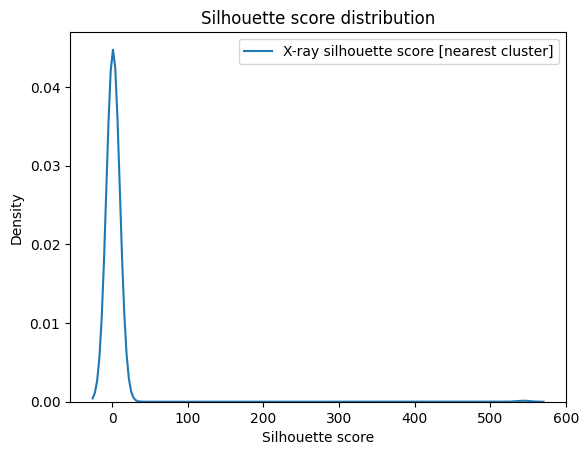

In [71]:
sns.kdeplot(da.xray_phi_psi.new_score, label='X-ray silhouette score [nearest cluster]')
# sns.kdeplot(results.sil_score, label='Silhouette score [all clusters]')
plt.xlabel('Silhouette score')
plt.ylabel('Density')
plt.title('Silhouette score distribution')
plt.legend()

In [82]:
np.histogram(da.phi_psi_predictions.new_score.dropna().values, bins=10)

(array([156630,     24,     51,    155,     52,     46,     27,      4,
             6,      4]),
 array([6.20038670e-01, 1.92851090e+02, 3.85082142e+02, 5.77313194e+02,
        7.69544245e+02, 9.61775297e+02, 1.15400635e+03, 1.34623740e+03,
        1.53846845e+03, 1.73069950e+03, 1.92293056e+03]))

<Axes: >

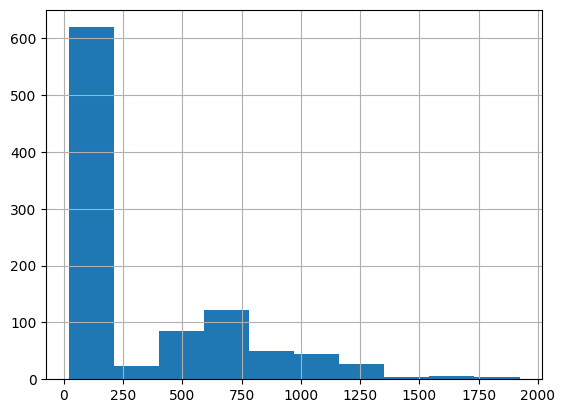

In [94]:
da.phi_psi_predictions[da.phi_psi_predictions.new_score > 20].new_score.hist()

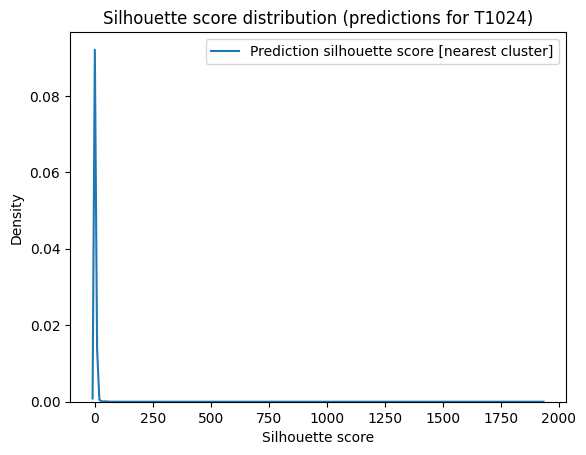

In [102]:
sns.kdeplot(da.phi_psi_predictions.new_score, label='Prediction silhouette score [nearest cluster]')
plt.xlabel('Silhouette score')
plt.ylabel('Density')
plt.title('Silhouette score distribution (predictions for T1024)')
plt.legend()

Text(0.5, 1.0, 'Sil score heatmap for predictions (rows sorted by GDT_TS descending)')

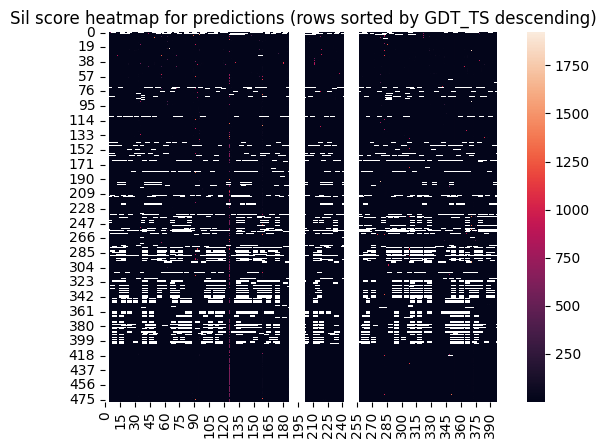

In [101]:
grouped_preds = da.phi_psi_predictions.pivot(index='protein_id', columns='pos', values='new_score')
grouped_preds_na = grouped_preds.isna().sum(axis=1)
grouped_preds[grouped_preds_na < grouped_preds_na.quantile(0.8)]
sns.heatmap(grouped_preds.loc[da.grouped_preds.sort_values('GDT_TS').protein_id.values].values)
plt.title('Sil score heatmap for predictions (rows sorted by GDT_TS descending)')

Text(0.5, 0, 'Sum Silhouette score')

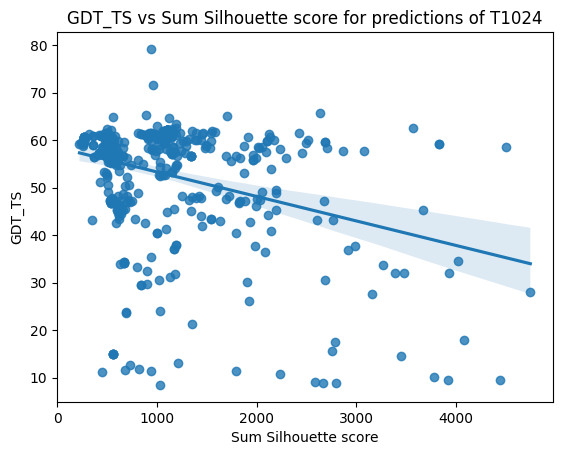

In [95]:
grouped_preds = da.phi_psi_predictions.groupby('protein_id').sum(numeric_only=True)
da.grouped_preds.set_index('protein_id', inplace=True)
da.grouped_preds.loc[grouped_preds.index, 'new_score'] = grouped_preds.new_score
da.grouped_preds.reset_index(inplace=True)
sns.regplot(x='new_score', y='GDT_TS', data=da.grouped_preds)
plt.title('GDT_TS vs Sum Silhouette score for predictions of T1024')
plt.ylabel('GDT_TS')
plt.xlabel('Sum Silhouette score')

16 cluster
 1     1162
 0      345
-1       66
 6       39
 13      21
 4       15
 12      15
 2       15
 8       14
 3       14
 14      10
 9       10
 10       9
 11       8
 7        7
 5        5
Name: count, dtype: int64
Intracluster 0 40.3032112597569
Xray: 1.0598420959271784


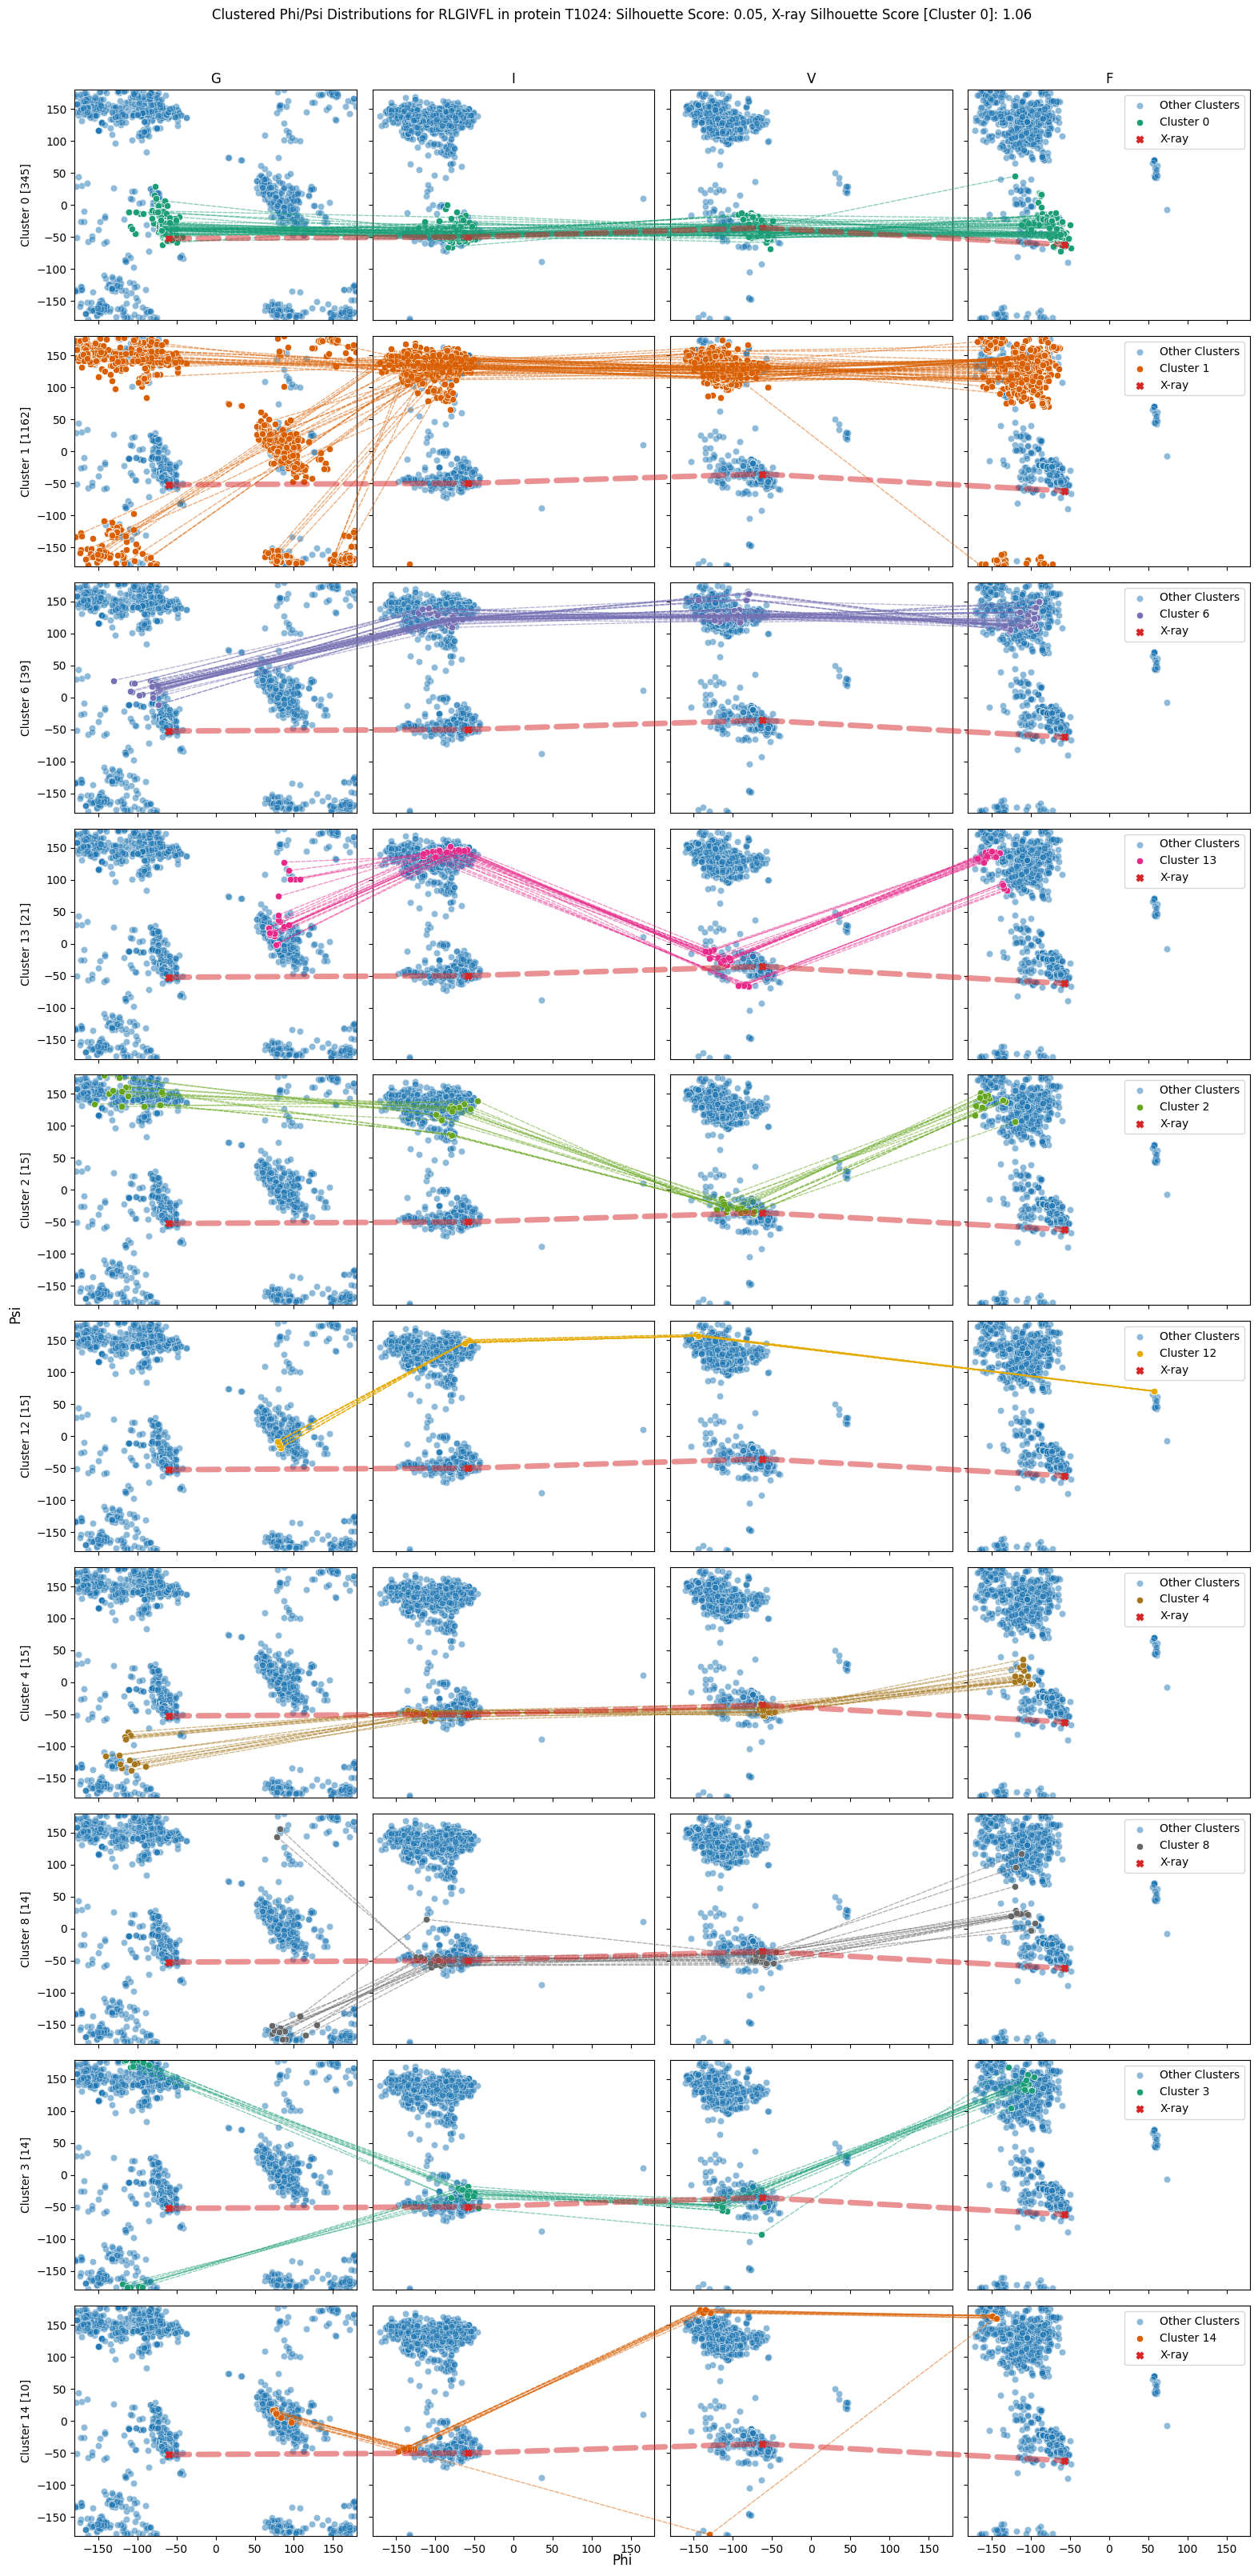

In [74]:
q = da.queries[0]
# seq_ctxt = da.seqs_for_window[3]
seq_ctxt = da.seqs[da.seqs.tolist().index('RLGIVFL')]
phi_psi_dist = get_phi_psi_dist(q, seq_ctxt)
xray_point, xrays = get_xrays(da, q, seq_ctxt, return_df=True)

# max_sil_avg = -1
# for k in range(2, min(phi_psi_dist.shape[0], 2**q.winsize)):
#     kmeans = KMeans(n_clusters=k).fit(phi_psi_dist.values)
#     sil_avg = silhouette_score(phi_psi_dist.values, kmeans.labels_)
#     if sil_avg > max_sil_avg:
#         max_sil_avg = sil_avg
#         phi_psi_dist['cluster'] = kmeans.labels_
#         chosen_centroids = kmeans.cluster_centers_
#         n_clusters = k

# phi_psi_dist['cluster'] = DBSCAN(eps=75, min_samples=5).fit(phi_psi_dist.values).labels_
# n_clusters = len(phi_psi_dist.cluster.unique())
# print(n_clusters, phi_psi_dist.cluster.value_counts())

precomputed_dists = precompute_dists(phi_psi_dist.iloc[:,:q.winsize*2])
n_clusters = assign_clusters(phi_psi_dist, precomputed_dists)
intracluster_dists = calc_intra_cluster(phi_psi_dist, precomputed_dists)
print(n_clusters, phi_psi_dist.cluster.value_counts())
sil_score = silhouette_score(phi_psi_dist[phi_psi_dist.cluster != -1].iloc[:,:-1], phi_psi_dist[phi_psi_dist.cluster != -1].cluster)
# print(sil_score)
# xray_sil, nearest_cluster = xray_sil_score(phi_psi_dist, xray_point, q)
xray_sil, nearest_cluster = calc_xray_score(phi_psi_dist, xray_point, q, intracluster_dists)
print('Intracluster', nearest_cluster, intracluster_dists[nearest_cluster])
print('Xray:', xray_sil)

clusters = phi_psi_dist[phi_psi_dist.cluster != -1].groupby('cluster').count().sort_values('phi_0', ascending=False).index.values
clusters = np.concatenate([[nearest_cluster], clusters[clusters != nearest_cluster]])
clusters_plot = clusters[:10]

# cluster_aves = phi_psi_dist.groupby('cluster').mean().loc[clusters_plot]

colors = sns.color_palette('Dark2', n_clusters)
fig, axes = plt.subplots(len(clusters_plot), q.winsize, figsize=(16, 32), sharey=True, sharex=True)
for i,axrow in enumerate(axes):
    for j, ax in enumerate(axrow):
        cluster_dist = phi_psi_dist[phi_psi_dist.cluster == clusters_plot[i]]

        sns.scatterplot(data=phi_psi_dist[phi_psi_dist.cluster != clusters_plot[i]], x=f'phi_{j}', y=f'psi_{j}', ax=ax, label='Other Clusters', color='tab:blue', alpha=0.5)
        sns.scatterplot(data=cluster_dist, x=f'phi_{j}', y=f'psi_{j}', ax=ax, label=f'Cluster {clusters_plot[i]}', color=colors[i])
        ax.scatter(xrays.phi.iloc[j], xrays.psi.iloc[j], color='tab:red', marker='X', label='X-ray', zorder=1000)
        # ax.scatter(cluster_aves.loc[clusters_plot[i]].values.reshape(2,-1)[0,j], cluster_aves.loc[clusters_plot[i]].values.reshape(2,-1)[1,j], color='tab:green', marker='X', label='Cluster Centroid', zorder=1000)

        def add_conn(xyA, xyB, color, lw, **kwargs):
            con = ConnectionPatch(
                xyA=xyA, 
                xyB=xyB, 
                coordsA="data", coordsB="data", 
                axesA=axrow[j], axesB=axrow[j+1], 
                color=color, lw=lw, linestyle='--', alpha=0.5, **kwargs
            )
            fig.add_artist(con)
        if j < q.winsize - 1:
            # TODO draw lines for 50 points closest to centroid
            for k, row in cluster_dist.sample(min(cluster_dist.shape[0], 50)).iterrows():
                add_conn((row[f'phi_{j}'], row[f'psi_{j}']), (row[f'phi_{j+1}'], row[f'psi_{j+1}']), colors[i], 1)
            add_conn((xrays.phi.iloc[j], xrays.psi.iloc[j]), (xrays.phi.iloc[j+1], xrays.psi.iloc[j+1]), 'tab:red', 5, zorder=100)

        ax.set_xlim(-180, 180)
        ax.set_ylim(-180, 180)
        ax.set_xlabel('')
        if j == q.winsize - 1:
            ax.legend()
        else:
            ax.legend().remove()
        if i == 0:
            ax.set_title(xrays.iloc[j].res)
        if j == 0:
            ax.set_ylabel(f'Cluster {clusters_plot[i]} [{cluster_dist.shape[0]}]')
fig.supxlabel('Phi')
fig.supylabel('Psi')
fig.suptitle(
    f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}: Silhouette Score: {sil_score:.2f}, X-ray Silhouette Score [Cluster {nearest_cluster}]: {xray_sil:.2f}', 
    y=1.01
)
plt.tight_layout()